In [1]:
import pandas as pd
import os

In [2]:
os.chdir('C:/Users/POZOLE/Documents/pp/nohtyp/practice_algo_trading/modelos_dummys_ver2.0/data_modelos_dummys2.0')
data = pd.read_csv('modelo_supervisado_2.0.csv')

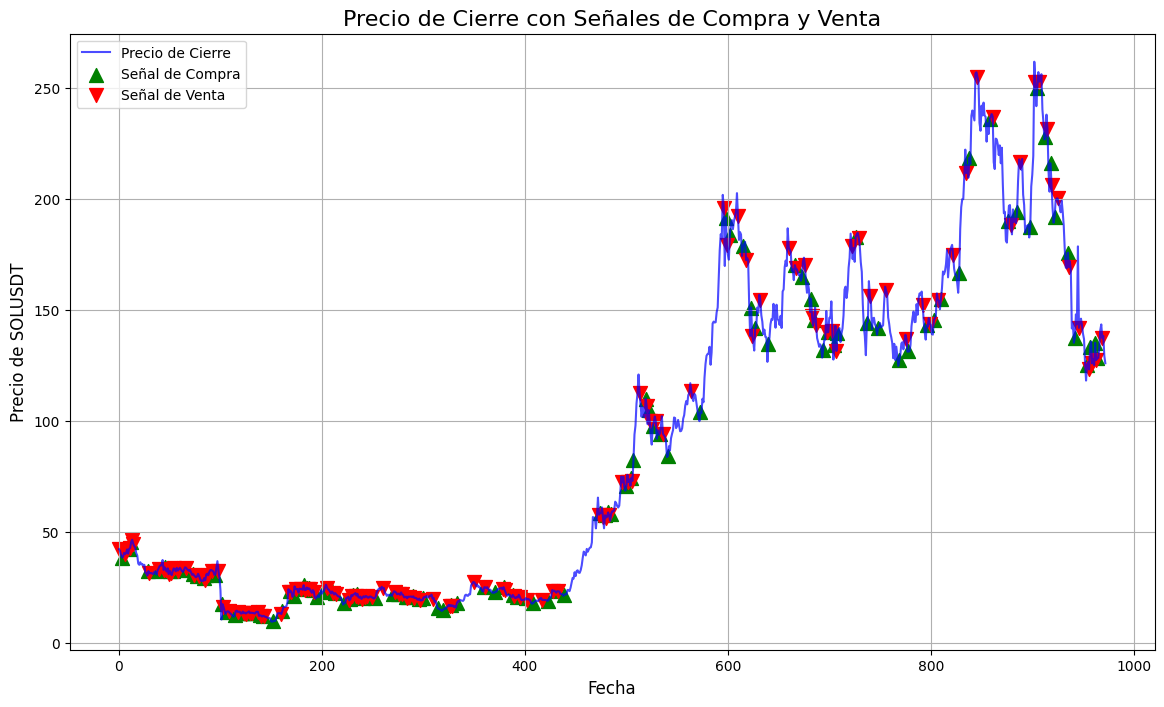

In [4]:
import matplotlib.pyplot as plt

# Crear gráfico de precios
plt.figure(figsize=(14, 8))
plt.plot(data['close'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
plt.scatter(data.index[data['buy_signal'] == 1], data['close'][data['buy_signal'] == 1], 
            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
plt.scatter(data.index[data['sell_signal'] == 1], data['close'][data['sell_signal'] == 1], 
            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)

# Personalización del gráfico
plt.title('Precio de Cierre con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Precio de {'SOLUSDT'}', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Mostrar gráfico
plt.show()

In [4]:
import pandas as pd
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 📌 1. Cargar datos
df = data.copy()

# Definir las características y la señal de trading
features = ['open', 'value', 'rsi', 'macd', 'adx', 'adp', 'adm', 'dri',
            'dlogri', 'avgtr', 'donch_hband', 'donch_lband', 'vwap']
target = 'signals'

# Escalar las características
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# 📌 2. Crear el entorno de trading personalizado
class CryptoTradingEnv(gym.Env):
    def __init__(self, df):
        super(CryptoTradingEnv, self).__init__()
        self.df = df
        self.current_step = 0
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.holdings = 0
        self.action_space = spaces.Discrete(3)  # 0 = Hold, 1 = Buy, 2 = Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(len(features),), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.holdings = 0
        return self.df.iloc[self.current_step][features].values.astype(np.float32)

    def step(self, action):
        prev_balance = self.balance
        prev_holdings = self.holdings
        price = self.df.iloc[self.current_step]['open']

        if action == 1:  # Buy
            self.holdings += self.balance / price
            self.balance = 0
        elif action == 2 and self.holdings > 0:  # Sell
            self.balance += self.holdings * price
            self.holdings = 0

        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        reward = self.balance + (self.holdings * price) - prev_balance
        obs = self.df.iloc[self.current_step][features].values.astype(np.float32)

        return obs, reward, done, {}

# 📌 3. Crear el entorno
env = DummyVecEnv([lambda: CryptoTradingEnv(df)])

# 📌 4. Entrenar el modelo PPO
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003, n_steps=512, batch_size=64, gamma=0.99)
model.learn(total_timesteps=100000)

# 📌 5. Evaluación y Predicciones
obs = env.reset()
predictions = []

for i in range(len(df)):
    action, _states = model.predict(obs, deterministic=True)
    predictions.append(action[0])
    obs, _, done, _ = env.step(action)
    if done:
        break



c:\Users\POZOLE\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
----------------------------
| time/              |     |
|    fps             | 726 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 649           |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 1.5948899e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -3.1e-06      |
|    learning_rate        | 0.0003        |
|    loss                 | 2.04e+10      |
|    n_updates            | 10            |
|    policy_gradient_loss | -1.2e-05      |
|    value_loss           | 4.32e+10      |
--------------------------------

In [8]:
# Asegurar que predictions tenga la misma longitud que df
obs = env.reset()
predictions = []

for i in range(len(df)):
    action, _states = model.predict(obs, deterministic=True)
    predictions.append(action[0])
    obs, _, done, _ = env.step(action)
    
    # Evitar que se detenga antes de completar todas las filas
    if done and i < len(df) - 1:
        obs = env.reset()  # Reiniciar entorno si es necesario

# Ajustar la longitud si aún hay diferencia
if len(predictions) < len(df):
    predictions.extend([predictions[-1]] * (len(df) - len(predictions)))  # Rellenar con la última predicción
elif len(predictions) > len(df):
    predictions = predictions[:len(df)]  # Cortar exceso

# Asignar al DataFrame
df['predictions'] = predictions

# Mostrar resultados
print(df[['signals', 'predictions']].head(20))



   signals  predictions
0     sell            2
1     hold            2
2     hold            2
3      buy            2
4     hold            2
5     hold            2
6     sell            2
7     hold            2
8     hold            2
9     hold            2
10     buy            2
11    sell            2
12     buy            2
13    sell            2
14    sell            2
15    hold            2
16    hold            2
17    hold            2
18    hold            2
19    hold            2


In [10]:
from sklearn.metrics import confusion_matrix

# Mapeo de valores numéricos a etiquetas de texto
label_mapping = {0: "Hold", 1: "Buy", 2: "Sell"}

# Convertir predicciones numéricas a texto
df['predictions'] = [label_mapping[p] for p in predictions]

# Matriz de confusión
cm = confusion_matrix(df['signals'], df['predictions'])
print(cm)


[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [ 36  11  75   0   0   0]
 [323  22 383   0   0   0]
 [ 51   1  71   0   0   0]]


In [11]:
df['correcto'] = df['signals'] == df['predictions']
df[['signals', 'predictions', 'correcto']].head(20)


,signals,predictions,correcto
0,sell,Sell,False
1,hold,Sell,False
2,hold,Sell,False
3,buy,Sell,False
4,hold,Sell,False
5,hold,Sell,False
6,sell,Sell,False
7,hold,Sell,False
8,hold,Sell,False
9,hold,Sell,False


In [16]:
import numpy as np

# Si 'predicted_signals' está en df, haz lo siguiente:
df['buy_signal_pred'] = np.where(df['predictions'] == 'Buy', 1, 0)
df['sell_signal_pred'] = np.where(df['predictions'] == 'Sell', 1, 0)

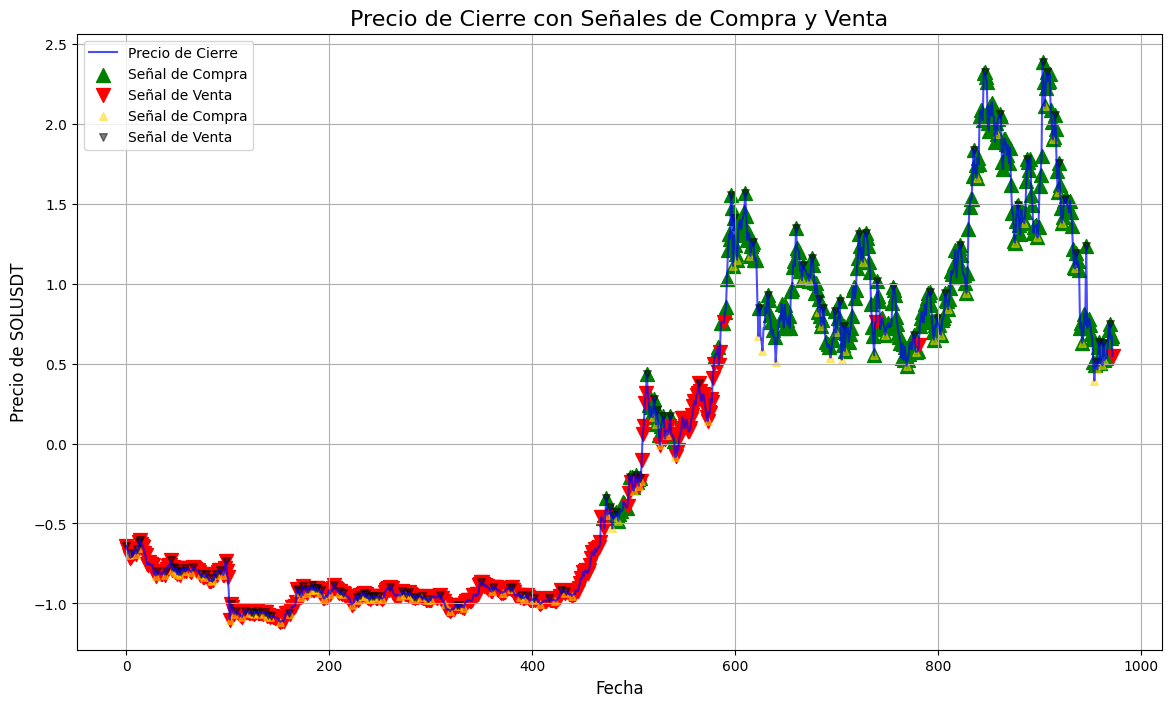

In [17]:
import matplotlib.pyplot as plt

# Crear gráfico de precios
plt.figure(figsize=(14, 8))
plt.plot(df['open'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
plt.scatter(df.index[df['buy_signal_pred'] == 1], df['open'][df['buy_signal_pred'] == 1], 
            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
plt.scatter(df.index[df['sell_signal_pred'] == 1], df['open'][df['sell_signal_pred'] == 1], 
            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)
plt.scatter(df.index[df['buy_signal'] == 1], df['open'][df['buy_signal'] == 1], 
            marker='^', color='gold', label='Señal de Compra', alpha=0.5, s=30)
plt.scatter(df.index[df['sell_signal'] == 1], df['open'][df['sell_signal'] == 1], 
            marker='v', color='black', label='Señal de Venta', alpha=0.5, s=30)

# Personalización del gráfico
plt.title('Precio de Cierre con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Precio de {'SOLUSDT'}', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Mostrar gráfico
plt.show()

Compra a -0.46597425852313645 en 13/11/2023
Venta a -0.5304040831739043 en 14/11/2023 | ROI: 13.83%
Compra a -0.338155142565444 en 16/11/2023
Venta a -0.3887944319658106 en 07/12/2023 | ROI: 14.98%
Compra a -0.20693695101786383 en 09/12/2023
Venta a -0.24330012294070238 en 10/12/2023 | ROI: 17.57%
Compra a -0.20778325147085616 en 11/12/2023
Venta a -0.26673293384405 en 14/12/2023 | ROI: 28.37%
Compra a -0.1958518024614547 en 15/12/2023
Venta a -0.2634587222554237 en 18/12/2023 | ROI: 34.52%
Compra a -0.21380447108722847 en 19/12/2023
Venta a -0.23365784728775593 en 20/12/2023 | ROI: 9.29%
Compra a 0.43146493987470347 en 26/12/2023
Venta a -0.0067799569961954015 en 08/01/2024 | ROI: -101.57%
Compra a 0.1114662521981401 en 09/01/2024
Venta a 0.030082670931687875 en 13/01/2024 | ROI: -73.01%
Compra a 0.08283077457557672 en 14/01/2024
Venta a 0.06171488458451965 en 16/01/2024 | ROI: -25.49%
Compra a 0.1702217016804833 en 18/01/2024
Venta a 0.062269835701236086 en 19/01/2024 | ROI: -63.42%


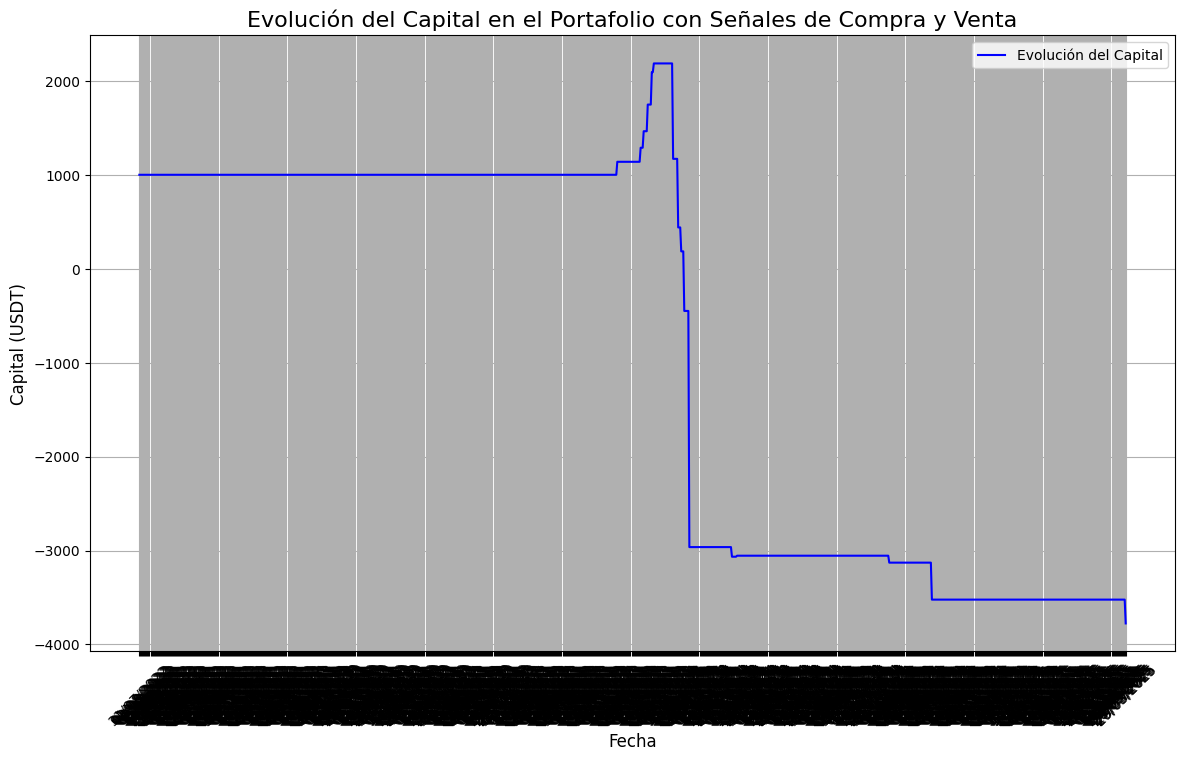

In [18]:
import pandas as pd

# Crear una copia del DataFrame
df_validation = df.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df_validation.iterrows():
    # Señal de compra
    if row['buy_signal_pred'] == 1 and not holding:
        buy_price = row['open']
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price} en {df_validation['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal_pred'] == 1 and holding:
        sell_price = row['open']
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price} en {df_validation['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_validation_capital = pd.DataFrame({
    'Date': df_validation['date'],
    'Capital': capital_history
})

# Graficar la evolución del capital a lo largo del tiempo
plt.figure(figsize=(14, 8))
plt.plot(df_validation_capital['Date'], df_validation_capital['Capital'], label='Evolución del Capital', color='blue')
plt.title('Evolución del Capital en el Portafolio con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Capital (USDT)', fontsize=12)
plt.grid(True)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()


Capital Final: 235.50 USDT
Tasa de Retorno Acumulado: -76.45%
Volatilidad Anualizada: 9.8445
Relación de Sharpe: -0.0030
Drawdown Máximo: -77.21%


C:\Users\POZOLE\AppData\Local\Temp\ipykernel_2600\161241951.py:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'])


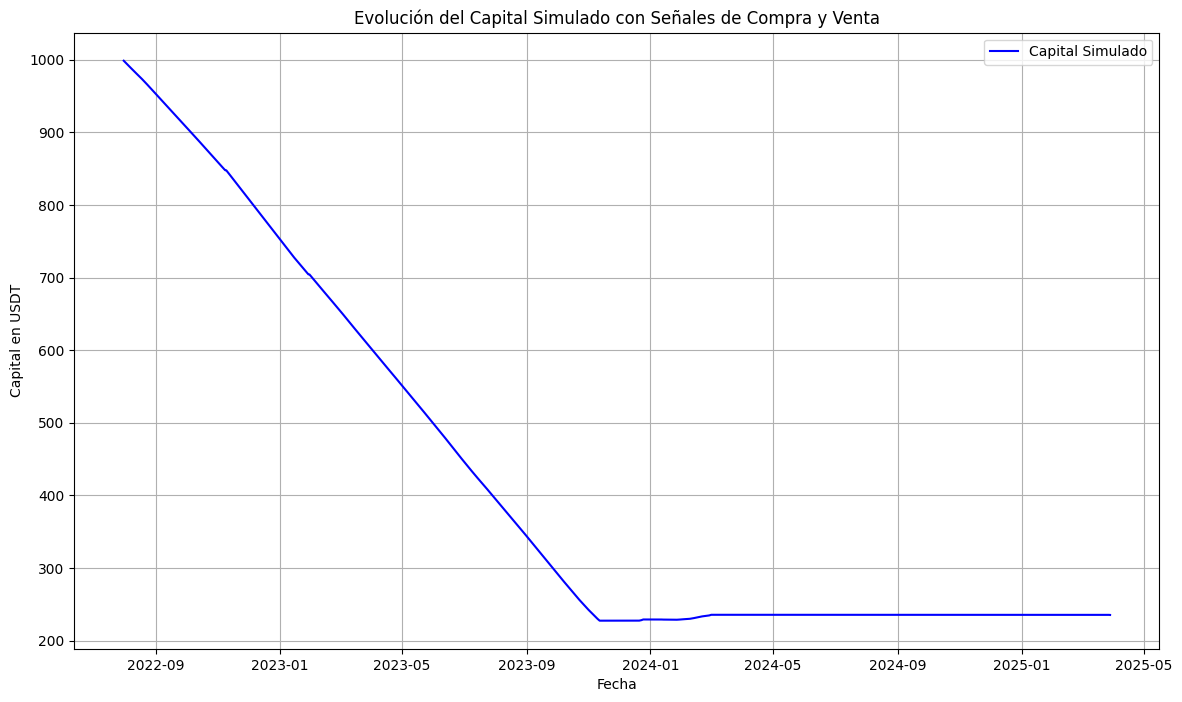

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Supongamos que tienes los datos necesarios con las señales predichas
# Aquí se toma el dataframe 'df' con las señales de compra y venta predichas

# Asegúrate de que las fechas estén en el formato correcto
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Calcula el retorno diario en base al precio 'open'
df['daily_return'] = df['open'].pct_change()

# Calcula el retorno acumulado de la inversión
initial_capital = 1000  # Capital inicial
df['capital'] = initial_capital * (1 + df['daily_return']).cumprod()

# Añadir señales de compra y venta al DataFrame
df['buy_signal'] = df['buy_signal_pred'] == 1
df['sell_signal'] = df['sell_signal_pred'] == 1

# Simular las compras y ventas
capital = initial_capital
capital_series = []

for i in range(len(df)):
    if df['buy_signal'].iloc[i]:
        buy_price = df['open'].iloc[i]
    if df['sell_signal'].iloc[i]:
        sell_price = df['open'].iloc[i]
        capital += (sell_price - buy_price)  # Calcular el retorno de la venta
    capital_series.append(capital)

df['capital_simulado'] = capital_series

# 1. Calcular el Drawdown
df['capital_max'] = df['capital_simulado'].cummax()
df['drawdown'] = df['capital_simulado'] - df['capital_max']
df['drawdown_pct'] = df['drawdown'] / df['capital_max'] * 100

# 2. Calcular la volatilidad (desviación estándar de los retornos diarios)
volatilidad = df['daily_return'].std() * np.sqrt(252)  # Volatilidad anualizada

# 3. Calcular la rentabilidad diaria promedio
rentabilidad_diaria = df['daily_return'].mean()

# 4. Calcular la relación de Sharpe
tasa_libre_riesgo = 0.01  # Asumimos una tasa libre de riesgo del 1%
sharpe_ratio = (rentabilidad_diaria - tasa_libre_riesgo) / volatilidad

# 5. Resultado Final
capital_final = df['capital_simulado'].iloc[-1]
tasa_retorno_acumulado = (capital_final - initial_capital) / initial_capital * 100

# Imprimir métricas de desempeño
print(f"Capital Final: {capital_final:.2f} USDT")
print(f"Tasa de Retorno Acumulado: {tasa_retorno_acumulado:.2f}%")
print(f"Volatilidad Anualizada: {volatilidad:.4f}")
print(f"Relación de Sharpe: {sharpe_ratio:.4f}")
print(f"Drawdown Máximo: {df['drawdown_pct'].min():.2f}%")

# Graficar la evolución del capital simulado
plt.figure(figsize=(14, 8))
plt.plot(df['date'], df['capital_simulado'], label='Capital Simulado', color='blue')
plt.title('Evolución del Capital Simulado con Señales de Compra y Venta')
plt.xlabel('Fecha')
plt.ylabel('Capital en USDT')
plt.grid(True)
plt.legend()
plt.show()


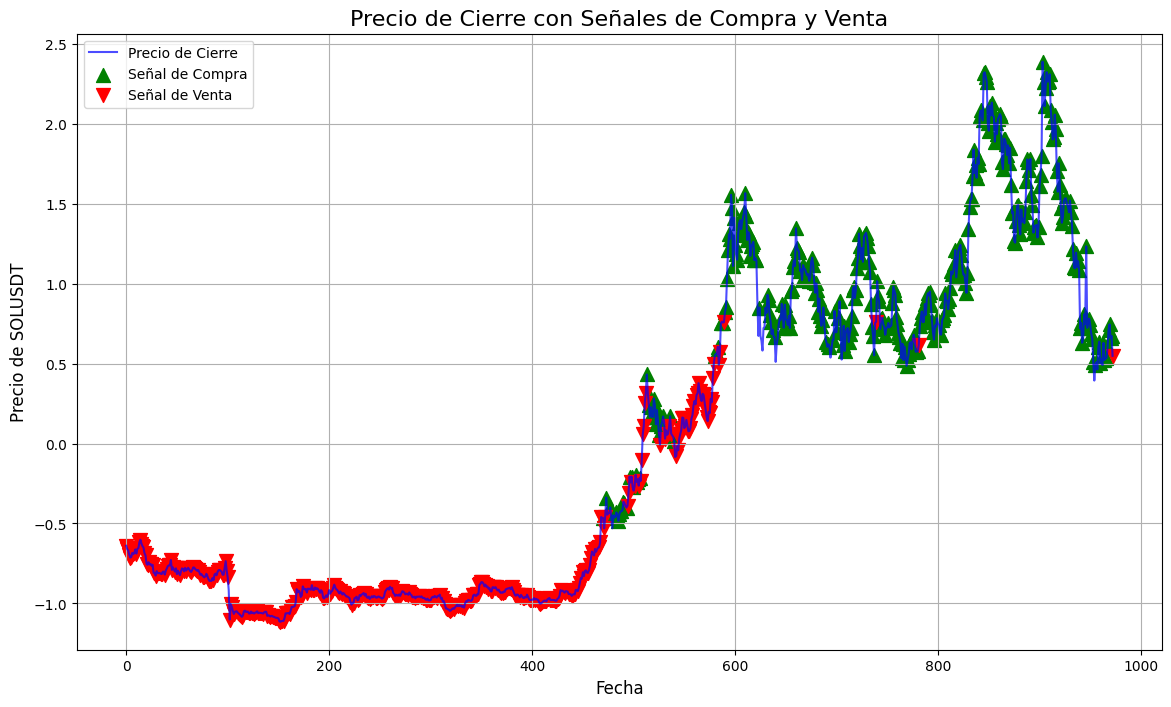

In [20]:
import matplotlib.pyplot as plt

# Crear gráfico de precios
plt.figure(figsize=(14, 8))
plt.plot(df['open'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
plt.scatter(df.index[df['buy_signal_pred'] == 1], df['open'][df['buy_signal_pred'] == 1], 
            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
plt.scatter(df.index[df['sell_signal_pred'] == 1], df['open'][df['sell_signal_pred'] == 1], 
            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)

# Personalización del gráfico
plt.title('Precio de Cierre con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Precio de {'SOLUSDT'}', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Mostrar gráfico
plt.show()